In [34]:
import pandas as pd
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer


In [35]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hienc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hienc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hienc\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
df = pd.read_csv("merged_movies.csv")


In [37]:
# Xóa dòng trùng
df = df.drop_duplicates()

# Xóa phim không có Plot hoặc Genre
df = df.dropna(subset=["Plot", "Genre"])

# Chuẩn hóa kiểu dữ liệu
df["Plot"] = df["Plot"].astype(str)
df["Genre"] = df["Genre"].astype(str)

print("Số phim sau cleaning:", len(df))

Số phim sau cleaning: 14563


In [38]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_plot(text):
    text = text.lower()                           # lowercase
    text = re.sub(r"[^a-z\s]", "", text)          # bỏ ký tự đặc biệt
    tokens = text.split()                         # tokenize
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(tokens)

df["Plot_clean"] = df["Plot"].apply(preprocess_plot)


In [39]:
df["Genre_list"] = df["Genre"].apply(lambda x: x.split(", "))


In [40]:
tfidf = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1, 2)
)

X_plot = tfidf.fit_transform(df["Plot_clean"])

print("Shape TF-IDF:", X_plot.shape)


Shape TF-IDF: (14563, 8000)


In [41]:
mlb = MultiLabelBinarizer()
X_genre = mlb.fit_transform(df["Genre_list"])

print("Shape Genre vector:", X_genre.shape)


Shape Genre vector: (14563, 14)


In [42]:
# ==============================
# TÁCH DATAFRAME (CÁCH 2)
# ==============================

df_full = df.copy()

# Data dùng cho MODEL
model_df = df_full[[
    "Title",
    "Plot_clean",
    "Genre_list"
]].reset_index(drop=True)

# Data dùng cho HIỂN THỊ
display_df = df_full[[
    "Title",
    "Genre",
    "Year",
    "imdbRating"
]].reset_index(drop=True)

# Kiểm tra đồng bộ
assert model_df["Title"].equals(display_df["Title"])

print("✅ Đã tách model_df và display_df")
print("MODEL DF:", model_df.shape)
print("DISPLAY DF:", display_df.shape)


✅ Đã tách model_df và display_df
MODEL DF: (14563, 3)
DISPLAY DF: (14563, 4)


In [43]:
model_df.to_csv("movies_model_Preprocessing.csv", index=False)

print("✅ Đã lưu file:")
print("- movies_model_Preprocessing.csv")


✅ Đã lưu file:
- movies_model_Preprocessing.csv


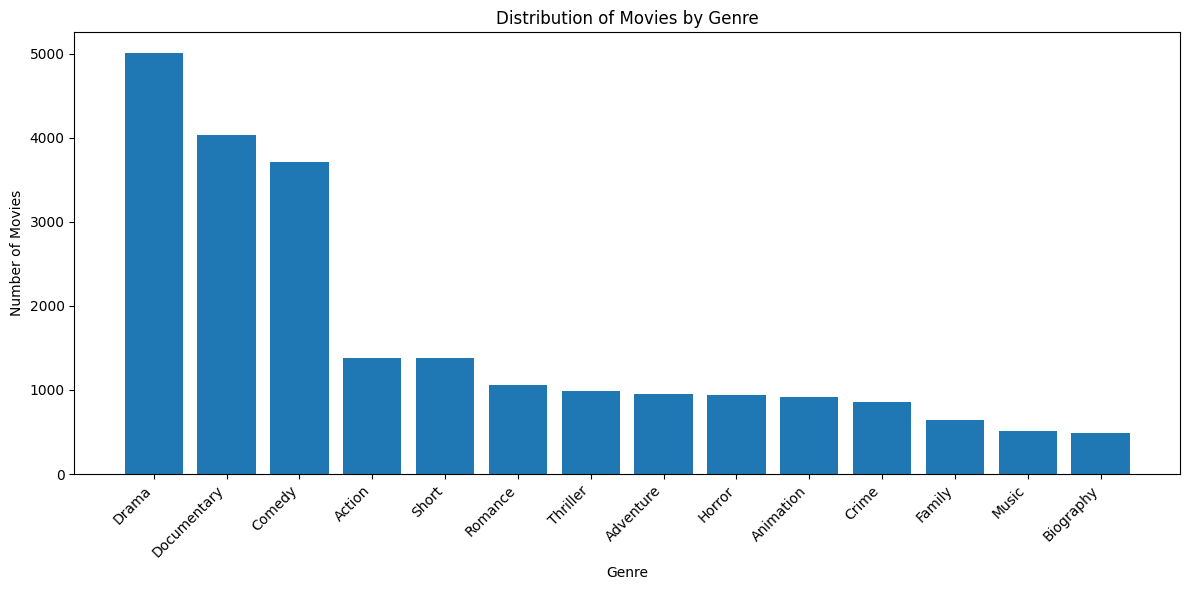

In [44]:
import matplotlib.pyplot as plt
from collections import Counter

# Đếm số phim theo thể loại
all_genres = [g for genres in df["Genre_list"] for g in genres]
genre_count = Counter(all_genres)

# Chuyển sang DataFrame
genre_df = pd.DataFrame(
    genre_count.items(),
    columns=["Genre", "Count"]
).sort_values("Count", ascending=False)

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.bar(genre_df["Genre"], genre_df["Count"])
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of Movies by Genre")
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()


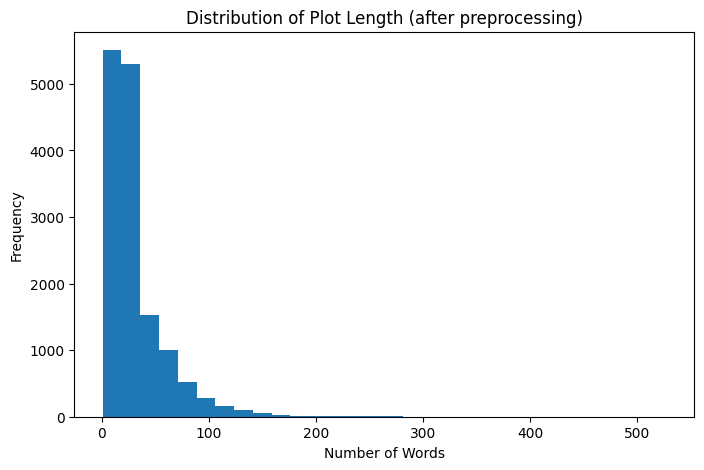

In [45]:
# Tính độ dài nội dung sau preprocessing
df["plot_length"] = df["Plot_clean"].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
plt.hist(df["plot_length"], bins=30)
plt.title("Distribution of Plot Length (after preprocessing)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


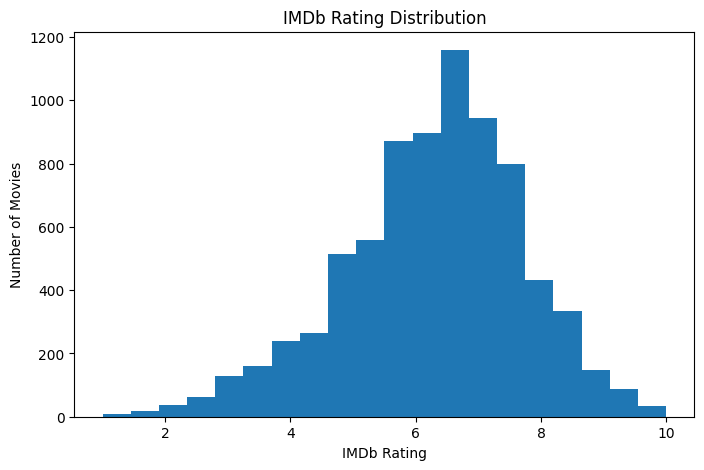

In [46]:
plt.figure(figsize=(8, 5))
plt.hist(df["imdbRating"].dropna(), bins=20)
plt.title("IMDb Rating Distribution")
plt.xlabel("IMDb Rating")
plt.ylabel("Number of Movies")
plt.show()


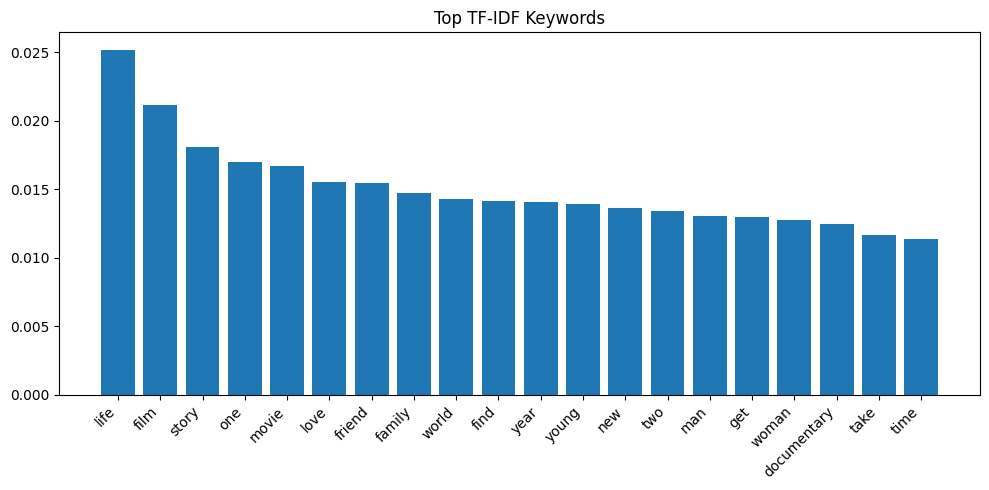

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf = TfidfVectorizer(max_features=3000)
tfidf_matrix = tfidf.fit_transform(model_df["Plot_clean"])

# Lấy trọng số trung bình của từ
mean_tfidf = tfidf_matrix.mean(axis=0).A1
terms = tfidf.get_feature_names_out()

top_words = pd.DataFrame({
    "word": terms,
    "score": mean_tfidf
}).sort_values("score", ascending=False).head(20)

# Vẽ
plt.figure(figsize=(10, 5))
plt.bar(top_words["word"], top_words["score"])
plt.xticks(rotation=45, ha="right")
plt.title("Top TF-IDF Keywords")
plt.tight_layout()
plt.show()


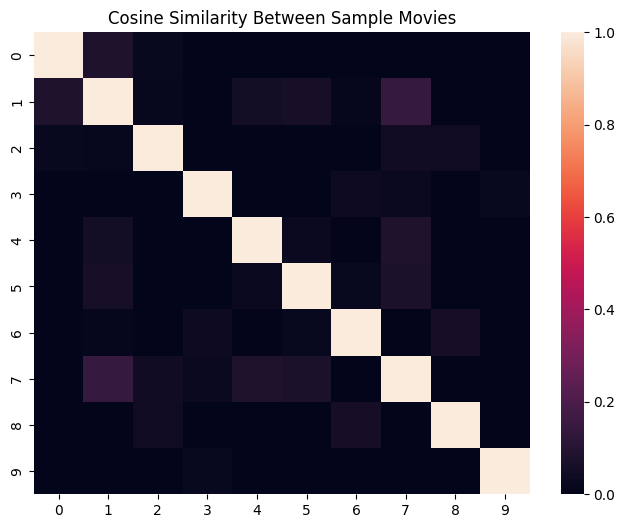

In [48]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

sample_sim = cosine_similarity(tfidf_matrix[:10])

plt.figure(figsize=(8, 6))
sns.heatmap(sample_sim, annot=False)
plt.title("Cosine Similarity Between Sample Movies")
plt.show()


In [49]:
df[["Title", "Plot_clean", "Genre_list"]].head()


,Title,Plot_clean,Genre_list
0,The Lego Movie 2: The Second Part,five year since everything awesome citizen fac...,"[Animation, Adventure, Comedy]"
1,PAW Patrol: The Movie,paw patrol biggest rival mayor humdinger becom...,"[Animation, Action, Adventure]"
2,Demon Slayer: Kimetsu no Yaiba - The Movie: Mu...,tanjiro kamado joined inosuke hashibira boy ra...,"[Animation, Action, Adventure]"
3,The Garfield Movie,garfield unexpected reunion longlost father ra...,"[Animation, Adventure, Comedy]"
4,The Bob's Burgers Movie,story begin ruptured water main creates enormo...,"[Animation, Adventure, Comedy]"
